In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import random
from datetime import datetime as dt
  
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torch.distributions as distributions
import torch.nn.functional as F
from torch.nn import Module, Parameter
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(20)
torch.manual_seed(20)

In [ ]:
def read_data():
  # Load CSV into dataframe and format
  df = pd.read_csv('final_daily.csv')
  df['date']=pd.to_datetime(df['date'])
  df=df[df['date']<datetime.datetime(2023,1,1)]

  variable = ['price', 'demand']

  scaler = MinMaxScaler()
  df[variable] = scaler.fit_transform(df[variable].values.reshape(-1, len(variable)))

  VAL_PERC = 0.30

  n_train = int(len(df[:-365]) * (1 - VAL_PERC))

  dataframe_train = df[variable][0:n_train]
  train_df = dataframe_train.values.reshape(-1, len(variable))

  dataframe_val = df[variable][n_train:-365]
  val_df = dataframe_val.values.reshape(-1, len(variable))

  dataframe_test = df[variable][-365:]
  test_df = dataframe_test.values.reshape(-1, len(variable))

  dataframe_dataset = df[variable][0:df.shape[0]]
  dataset= dataframe_dataset.values.reshape(-1, len(variable))

  return df, train_df, val_df, test_df, dataset, scaler

In [ ]:
def to_sequences(dataset, seq_size): # seq_size is Number of time steps to look back 
                                       #Larger sequences (look further back) may improve forecasting.
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), :]
        x.append(window)
        y.append(dataset[i+seq_size, :])
    print(np.array(x).shape)
        
    return np.array(x),np.array(y)

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 256)

        self.fc1 = nn.Linear(256, 128)

        self.fc2 = nn.Linear(128, output_dim)

        self.dropout = nn.Dropout(0.5)

        self.relu = nn.LeakyReLU()

        self.bn = nn.LazyBatchNorm1d()

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        out = self.relu(out)

        out = self.fc1(out)

        out = self.relu(out)

        out = self.fc2(out)

        return out  

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        #x = torch.squeeze(x)

        #ones = torch.ones_like(x)

        #masked = torch.where(x > 0, ones, 0.)

        #print(masked)

        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)


        # Returns the loss
        return yhat, loss.item()


    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
      early_stopping = EarlyStopping(patience=20)


      for epoch in range(1, n_epochs + 1):
          train_pred = []
          val_pred = []
          batch_losses = []
          validation_loss = 0
          training_loss = 0
          for x_batch, y_batch in train_loader:
              x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
              y_batch = y_batch.to(device)
              yhat, loss = self.train_step(x_batch, y_batch)
              batch_losses.append(loss)
              train_pred.append(yhat.detach().numpy())
          training_loss = np.mean(batch_losses)
          self.train_losses.append(training_loss)

          with torch.no_grad():
              batch_val_losses = []
              for x_val, y_val in val_loader:
                  x_val = x_val.view([batch_size, -1, n_features]).to(device)
                  y_val = y_val.to(device)
                  self.model.eval()
                  yhat = self.model(x_val)
                  val_loss = self.loss_fn(y_val, yhat).item()
                  batch_val_losses.append(val_loss)
                  val_pred.append(yhat.numpy())
              validation_loss = np.mean(batch_val_losses)
              self.val_losses.append(validation_loss)

          print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.10f}\t Validation loss: {validation_loss:.10f}")

          # early stopping
          early_stopping(validation_loss)
          if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break
      return np.array(train_pred), np.array(val_pred)


    def plot_losses(self):
      plt.plot(self.train_losses, label="Training loss")
      plt.plot(self.val_losses, label="Validation loss")
      plt.legend()
      plt.title("Losses")
      plt.show()
      plt.close()
    

    def evaluate(self, test_loader, batch_size=1, n_features=1):
    
      with torch.no_grad():
          testPredict = []
          testValues = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              testPredict.append(yhat.to(device).detach().numpy())
              testValues.append(y_test.to(device).detach().numpy())

      return np.array(testPredict), np.array(testValues)

In [ ]:
def plotting (dataset, trainPredict, valPredict, testPredict, fcs = None):
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
    ext = 0

    if fcs is not None:
      ext = fcs.shape[0]

    trainPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

    # shift val predictions for plotting
    valPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(trainPredict)+(seq_size*2)+1-1:len(trainPredict)+len(valPredict)+(seq_size*2), :] = valPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+len(valPredict)+(seq_size*3)+1:len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+1, :] = testPredict

    if fcs is not None:
      fcPredictPlot = np.empty((dataset.shape[0] + ext, dataset.shape[1]))
      fcPredictPlot[:, :] = np.nan
      fcPredictPlot[len(trainPredict)+len(valPredict)+len(testPredict)+(seq_size*3)+2:len(dataset)+ext-1, :] = fcs

    # plot baseline and predictions
    plt.plot(dataset, color='k', label='dataset')
    plt.plot(trainPredictPlot, color='b', label='train', linestyle='dashed')
    plt.plot(valPredictPlot, color='g', label='val', linestyle='dashed')
    plt.plot(testPredictPlot, color='r', label='test', linestyle='dashed')
    if fcs is not None:
      plt.plot(fcPredictPlot, color='m', label='forecasts', linestyle='dashed')
    plt.legend(loc="upper left")
    plt.title("Prediction")
    plt.xlabel("Time")
    plt.ylabel("Cases")
    mpl.rcParams['figure.dpi'] = 300
    plt.show()

    return

In [ ]:
df, train, val, test, dataset, scaler = read_data()

In [ ]:
seq_size = 16
batch_size = 1

# convert dataset into input/output
trainX, trainY = to_sequences(train, seq_size)
valX, valY = to_sequences(val, seq_size)
testX, testY = to_sequences(test, seq_size)

train_features = torch.Tensor(trainX)
train_targets = torch.Tensor(trainY)

val_features = torch.Tensor(valX)
val_targets = torch.Tensor(valY)

test_features = torch.Tensor(testX)
test_targets = torch.Tensor(testY)

train = TensorDataset(train_features, train_targets)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)

val = TensorDataset(val_features, val_targets)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

test = TensorDataset(test_features, test_targets)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=False)

(494, 16, 2)
(203, 16, 2)
(348, 16, 2)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[1/500] Training loss: 0.0256592207	 Validation loss: 0.0456077886
[2/500] Training loss: 0.0120431989	 Validation loss: 0.0558564428
EarlyStopping counter: 1 out of 20
[3/500] Training loss: 0.0126771077	 Validation loss: 0.0644737698
EarlyStopping counter: 2 out of 20
[4/500] Training loss: 0.0134021402	 Validation loss: 0.0733276878
EarlyStopping counter: 3 out of 20
[5/500] Training loss: 0.0138895609	 Validation loss: 0.0857621912
EarlyStopping counter: 4 out of 20
[6/500] Training loss: 0.0140058122	 Validation loss: 0.0874982486
EarlyStopping counter: 5 out of 20
[7/500] Training loss: 0.0134442747	 Validation loss: 0.0804046318
EarlyStopping counter: 6 out of 20
[8/500] Training loss: 0.0121871567	 Validation loss: 0.0560977371
EarlyStopping counter: 7 out of 20
[9/500] Training loss: 0.0104346851	 Validation loss: 0.0438954137
[10/500] Training loss: 0.0090220879	 Validation loss: 0.0386528948
[11/500] Training loss: 0.0080427747	 Validation loss: 0.0364049779
[12/500] Trainin

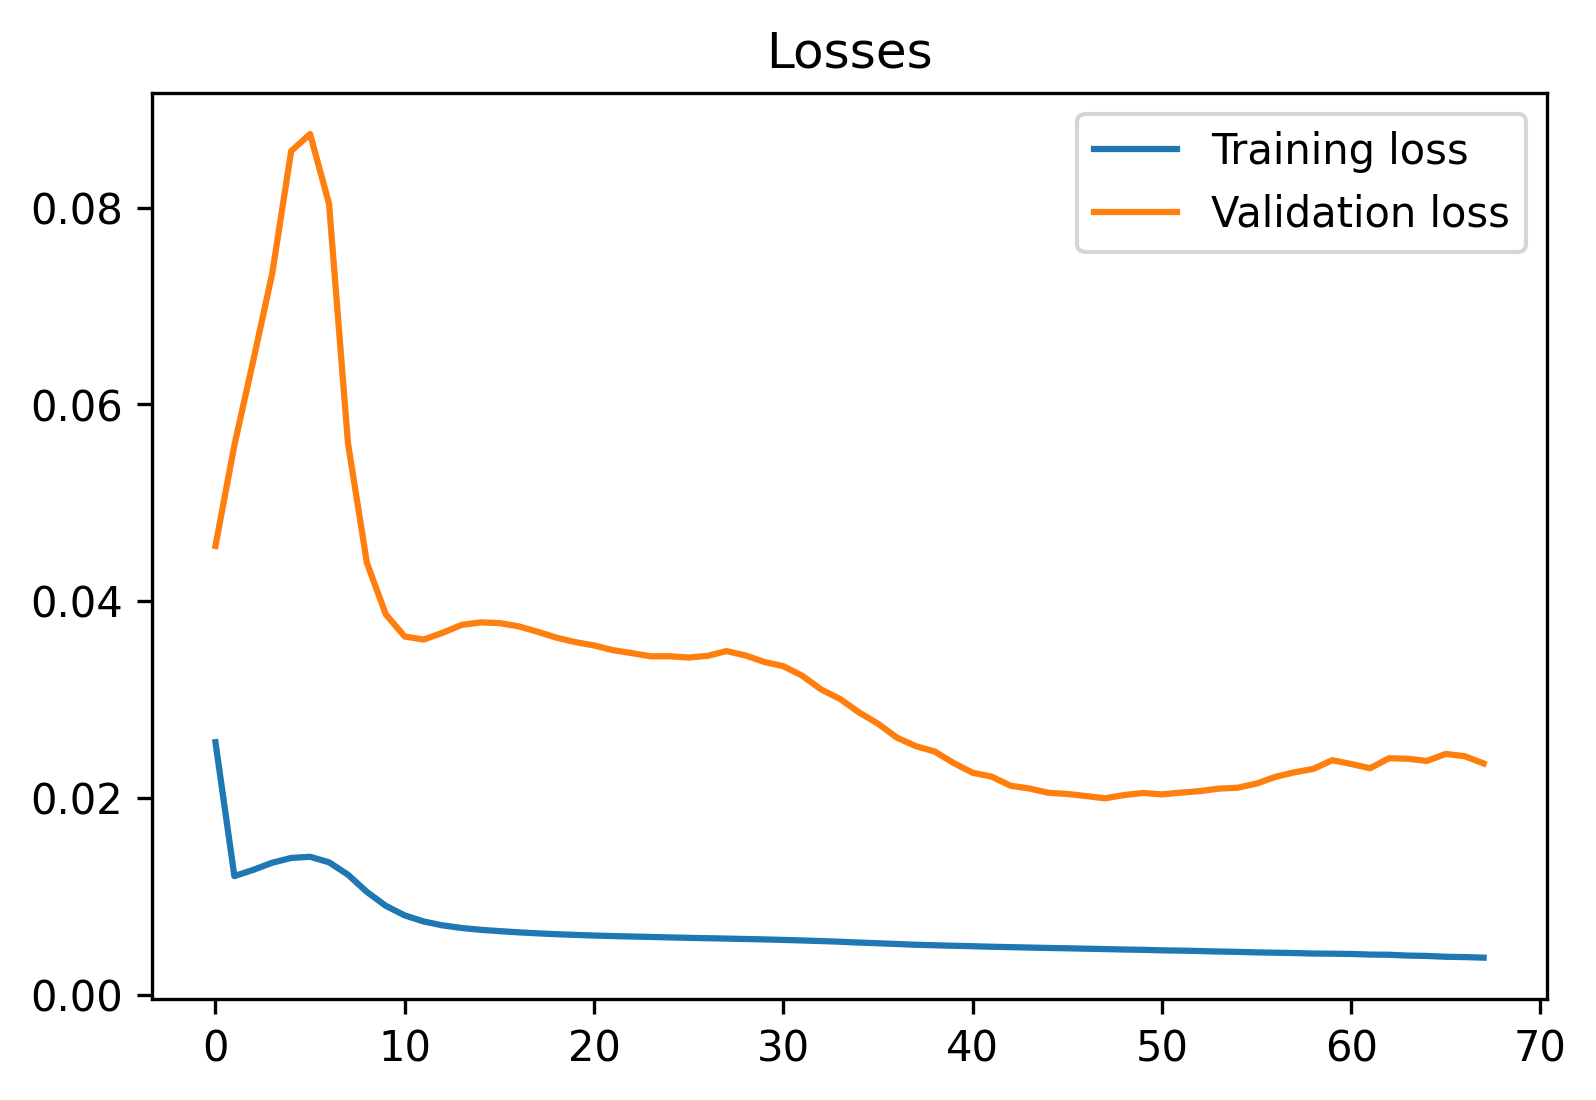

In [ ]:
input_dim = seq_size
output_dim = trainX.shape[2]
hidden_dim = 512
layer_dim = 2
dropout = 0
n_epochs = 500
learning_rate = 1e-4
weight_decay = 0

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

start = dt.now()

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
train_pred, val_pred = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

testPredict, testValues = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [ ]:
df_train = scaler.inverse_transform(train_pred.reshape(-1, 2))
df_val = scaler.inverse_transform(val_pred.reshape(-1, 2))
df_test = scaler.inverse_transform(testPredict.reshape(-1, 2))
dataset = scaler.inverse_transform(dataset)

In [ ]:
testPredict.shape

(348, 1, 2)

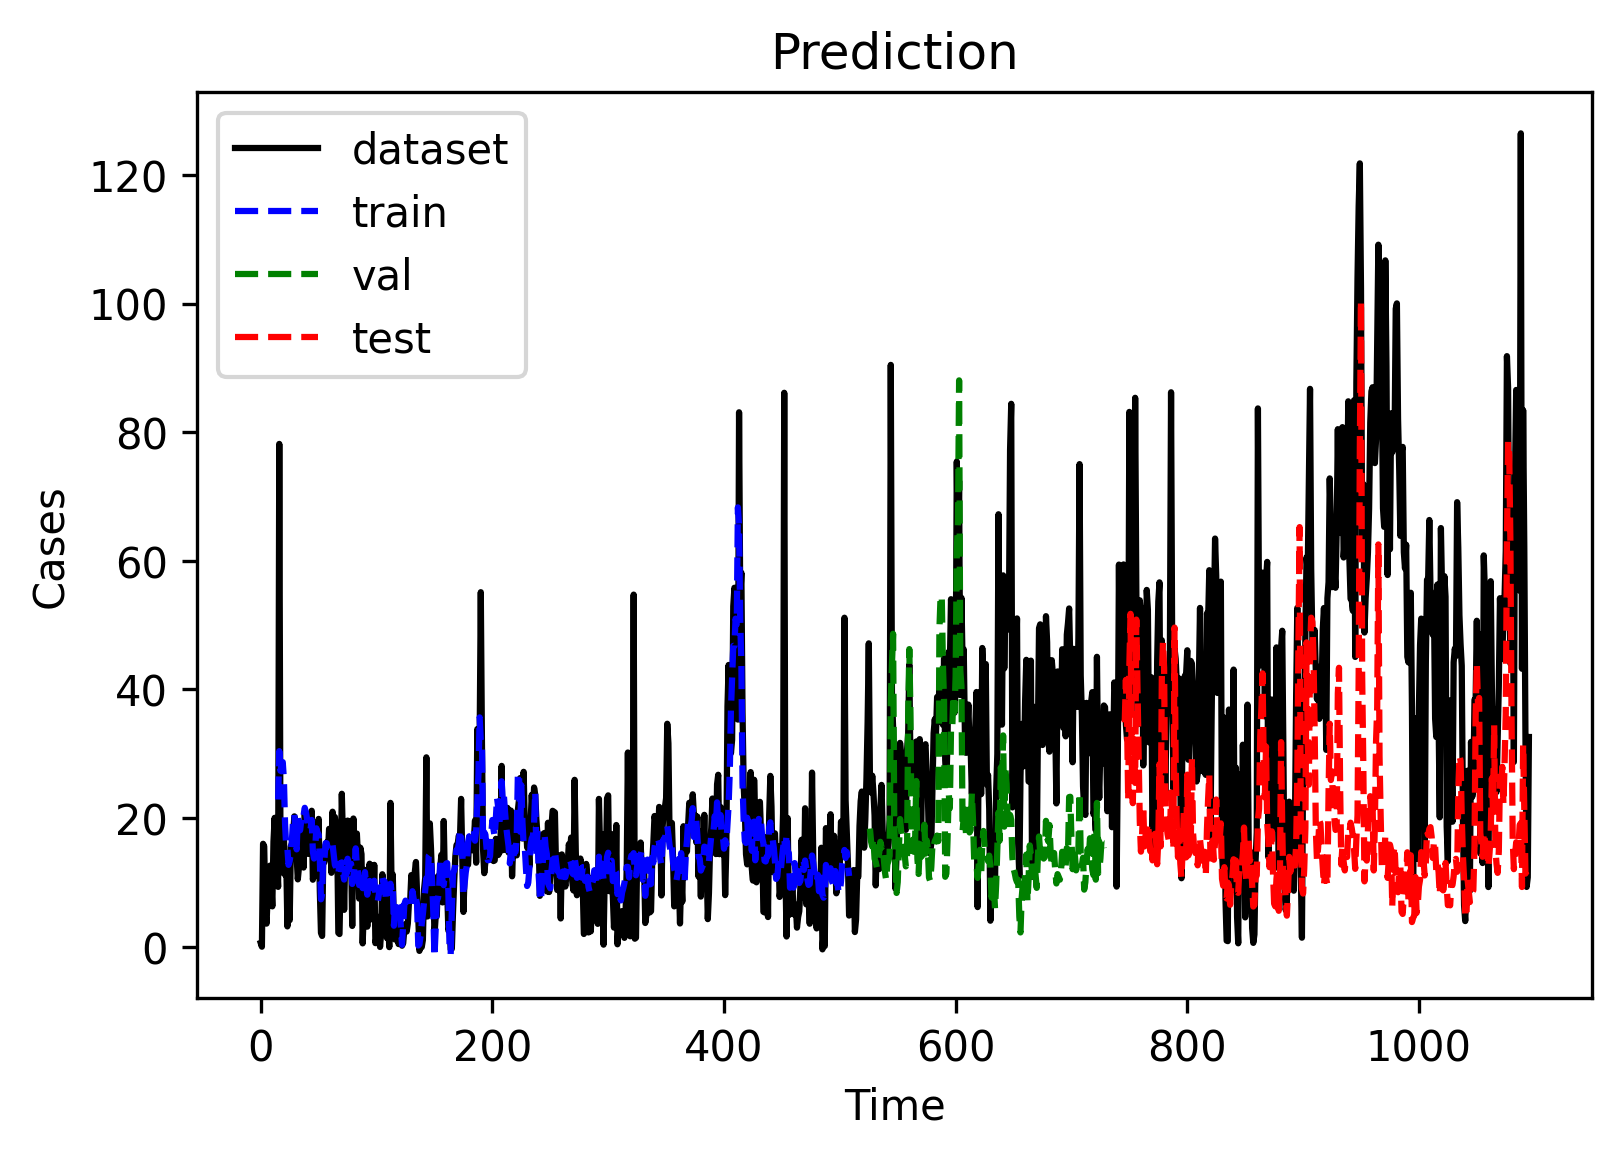

In [ ]:
plotting (dataset[:, 0].reshape(-1, 1), df_train[:, 0].reshape(-1, 1), df_val[:, 0].reshape(-1, 1), df_test[:, 0].reshape(-1, 1)) #plotting without inverse_transform

In [ ]:
np.square(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

1266.828661135002

In [ ]:
np.abs(df_test[:, 0] - scaler.inverse_transform(testY)[:, 0]).mean()

28.703972313787748

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 0], scaler.inverse_transform(testY)[:, 0])

0.7948066038825093

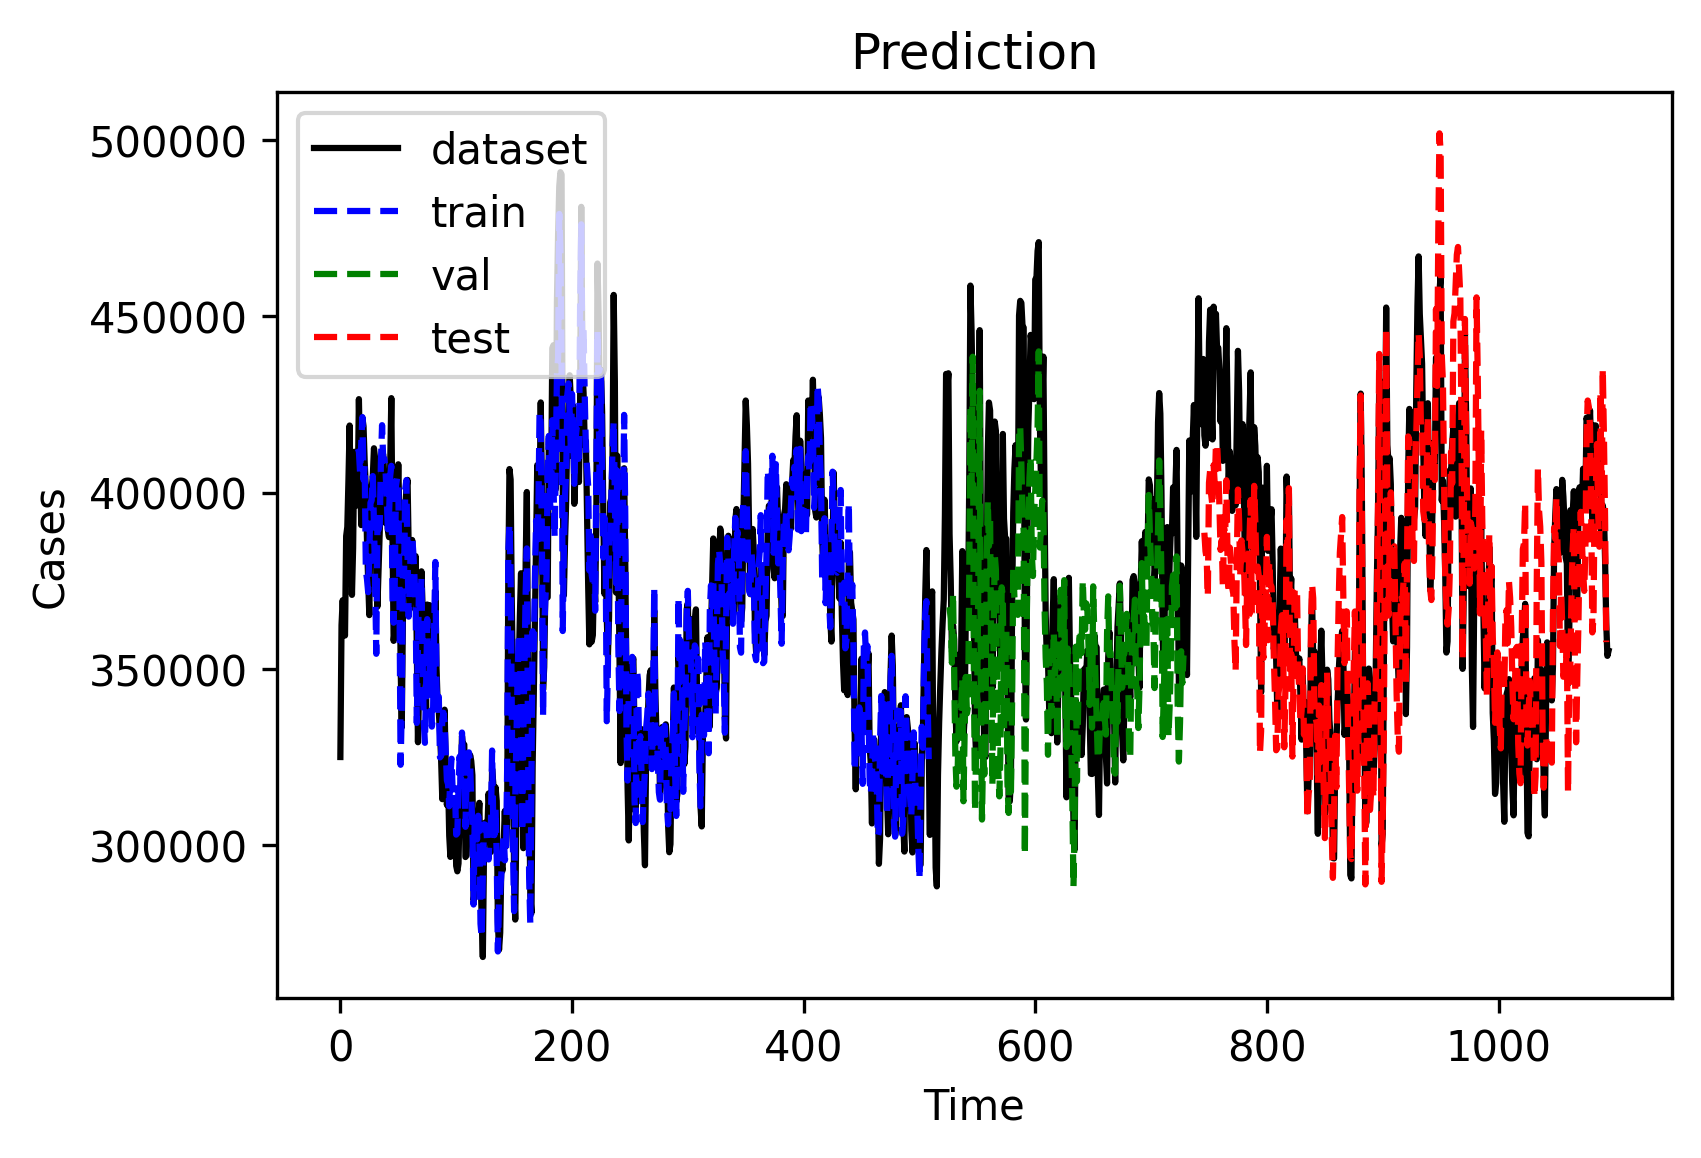

In [ ]:
plotting (dataset[:, 1].reshape(-1, 1), df_train[:, 1].reshape(-1, 1), df_val[:, 1].reshape(-1, 1), df_test[:, 1].reshape(-1, 1)) #plotting without inverse_transform

In [ ]:
np.square(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

845069403.3450913

In [ ]:
np.abs(df_test[:, 1] - scaler.inverse_transform(testY)[:, 1]).mean()

23636.191630747126

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(df_test[:, 1], scaler.inverse_transform(testY)[:, 1])

0.06338243039531136